# Optimize EV Charging Load

**Author:** Eleanor Adachi

**Last updated:** 9/24/2024

**Description:** This is a full test of the new EV charging optimization algorithm for one year and one "scenario set" for all ~3000 circuits.

**NOTE: Approx. ~1000 circuits are excluded from the optimization due to incomplete data.**

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from optimize_ev_load import *

In [2]:
# inputs
yr = 2040
# load_sc_dict = {
#     '_description': 'high scenario for residential electrification + standard scenario for EV charging',
#     'EVres': 1,
#     'EVcom': 1, 
#     'RE': 4
#     }
load_sc_dict = {
    '_description': 'high scenario for building electrification + standard scenario for EV charging',
    'EVres': 1,
    'EVcom': 1, 
    'BE': 4
    }
feedlim_type = 'limit_b_md_kw'

In [3]:
# read in addload
addload_all = pd.read_csv(r'..\data\addload.csv')

# filter data
keep_cols = ['feeder_id', 'month', 'hour', 'mhid']
# for load_type in load_sc_dict.keys():
load_type_ls = list(filter(lambda x: not(x.startswith('_')), load_sc_dict.keys())) # exclude keys that start with underscore
for load_type in load_type_ls:
    sc_num = load_sc_dict[load_type]
    addload_all[load_type] = addload_all[f'ldinc_{load_type}{sc_num}_{yr}_kW']
    keep_cols.append(load_type)

addload = addload_all[ keep_cols ]

# filter out NaN
addload = addload.dropna()

# get list of unique load types
# other_loads = list(set(load_sc_dict.keys()) - set(['EVres', 'EVcom']))
other_loads = list(set(load_type_ls) - set(['EVres', 'EVcom']))
# combine other loads
addload['other'] = addload[ other_loads ].sum(axis=1)
# drop other loads
addload = addload.drop(columns=other_loads)

addload.head()

,feeder_id,month,hour,mhid,EVres,EVcom,other
3168,12011114,1,0,1,1850.682,38.478,1026.691
3169,12011114,1,1,2,1802.172,30.461,991.133
3170,12011114,1,2,3,1499.330,24.882,949.489
3171,12011114,1,3,4,1226.217,20.342,936.355
3172,12011114,1,4,5,1130.378,31.618,949.809


In [4]:
# read in feedlim
feedlim_all = pd.read_csv(r'..\data\feedlim.csv')

# filter feedlim
feedlim = feedlim_all[['feeder_id', 'month', 'hour', feedlim_type]]

# rename columns
feedlim = feedlim.rename(columns={feedlim_type: 'limit_kw'})

In [5]:
# merge addload and feedlim; INNER merge to ensure that data is available
input_df = pd.merge(addload, feedlim, how='inner', on=['feeder_id', 'month', 'hour'])

# compute pre-optimization hourly grid need
input_df['hourly_need'] = input_df['EVres'] + input_df['EVcom'] + input_df['other'] - input_df['limit_kw']

In [6]:
# create grid need dataframe

# NOTE: Positive "grid need" means that loads exceed limits (i.e. upgrades required), negative "grid need" means that there is "headroom"
gn_kw_df = pd.pivot_table(input_df, values='hourly_need', index='feeder_id', aggfunc='max')
gn_kw_df = gn_kw_df.reset_index()
gn_kw_df = gn_kw_df.rename(columns={'hourly_need':'gn_kw'})

In [7]:
# count number of circuits
feednum = len(input_df['feeder_id'].unique())
print('Number of feeders included in optimization: ', feednum)

Number of feeders included in optimization:  1965


In [8]:
# optimize EV charging
output_df, gn_kw_opt_df = optimize_ev_load(input_df)

C:\Users\elean\OneDrive_relink\OneDrive\Documents\UC Berkeley\ERG Masters Project\EV infrastructure\ccai-dac-grid\scripts\optimize_ev_load.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, output_df0], axis=0)


In [9]:
# compute post-optimization hourly grid need
output_df['hourly_need_opt'] = output_df['EVres_opt'] + output_df['EVcom_opt'] + output_df['other'] - output_df['limit_kw']

# preview outputs
output_df.head()

,feeder_id,month,hour,mhid,EVres,EVcom,other,limit_kw,hourly_need,EVres_opt,EVcom_opt,hourly_need_opt
0,12011114,1,0,1,1850.682,38.478,1026.691,2250.0,665.851,1307.372821,38.478,122.541821
1,12011114,1,1,2,1802.172,30.461,991.133,2260.0,563.766,1341.814579,30.461,103.408579
2,12011114,1,2,3,1499.330,24.882,949.489,2260.0,213.701,1372.735812,24.882,87.106812
3,12011114,1,3,4,1226.217,20.342,936.355,2260.0,-77.086,1384.465925,20.342,81.162925
4,12011114,1,4,5,1130.378,31.618,949.809,2260.0,-148.195,1368.077945,31.618,89.504945


In [10]:
# merge gn_kw_df and gn_kw_opt_df
gn_kw_df = pd.merge(gn_kw_df, gn_kw_opt_df, how='outer', on='feeder_id')

# zero out any negative values and change dtype to float
gn_kw_df['gn_kw'] = gn_kw_df['gn_kw'].clip(lower=0)
gn_kw_df['gn_kw_opt'] = gn_kw_df['gn_kw_opt'].clip(lower=0)
gn_kw_df['gn_kw'] = gn_kw_df['gn_kw'].astype('float')
gn_kw_df['gn_kw_opt'] = gn_kw_df['gn_kw_opt'].astype('float')

# preview results
gn_kw_df.head()

,feeder_id,gn_kw,gn_kw_opt
0,12011114,1001.775,952.734000
1,12011115,1697.202,1382.174668
2,12011116,726.505,241.896000
3,12011133,1493.727,1284.724170
4,12021103,0.000,0.000000


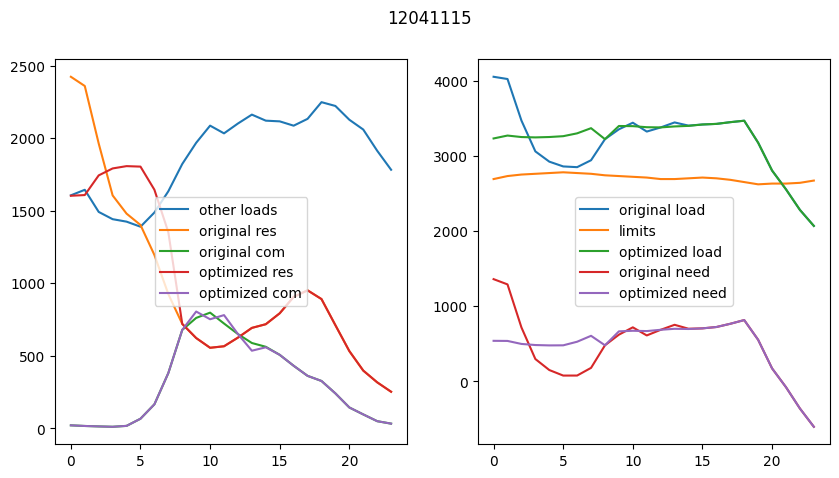

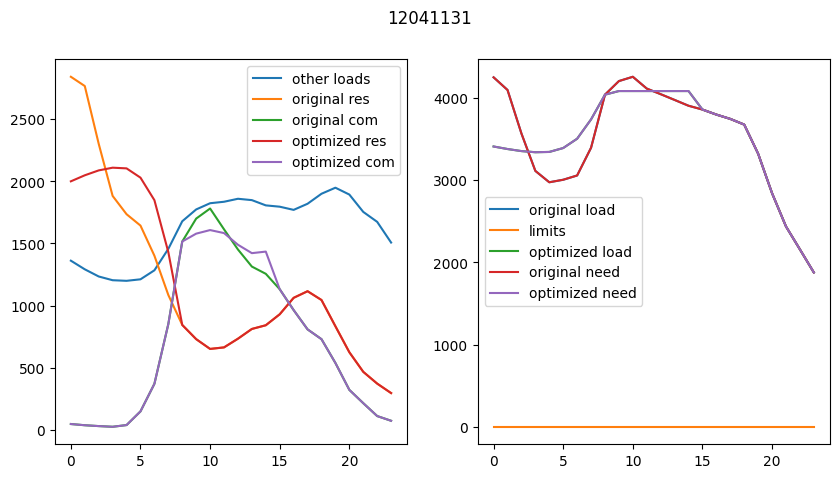

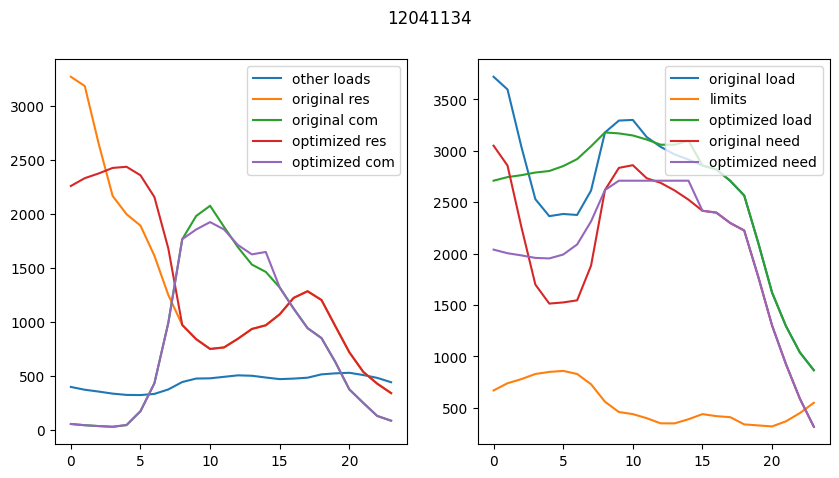

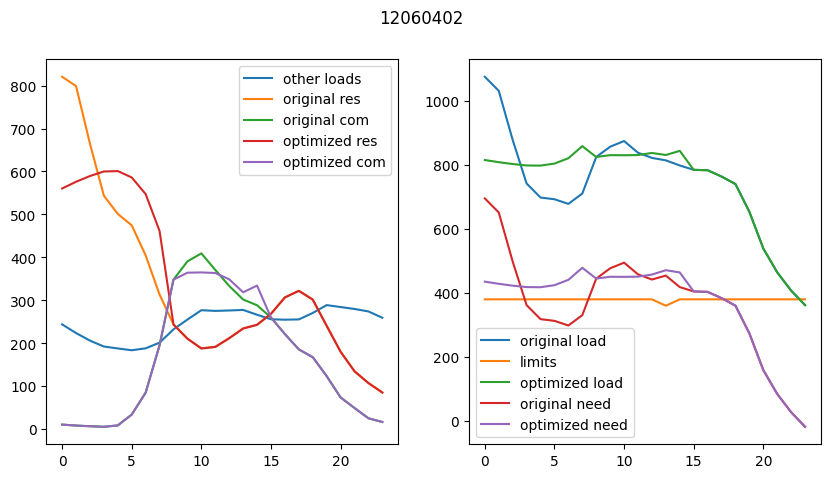

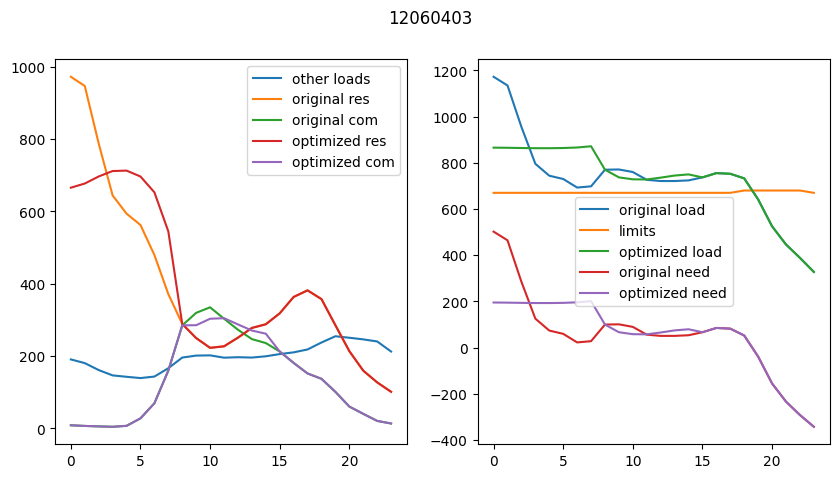

In [11]:
# make plots
plot_df = output_df.copy()
plot_df['add_kw'] = plot_df['EVres'] + plot_df['EVcom'] + plot_df['other']
plot_df['add_kw_opt'] = plot_df['EVres_opt'] + plot_df['EVcom_opt'] + plot_df['other']

feeders = list(plot_df.feeder_id.unique())

for feeder in feeders[20:25]:
# for feeder in feeders:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    plot_df0 = plot_df[ plot_df.feeder_id == feeder ]

    fig.suptitle(feeder)

    ax1.plot(range(24), plot_df0.other.iloc[:24], label='other loads')
    ax1.plot(range(24), plot_df0.EVres.iloc[:24], label='original res')
    ax1.plot(range(24), plot_df0.EVcom.iloc[:24], label='original com')
    ax1.plot(range(24), plot_df0.EVres_opt.iloc[:24], label='optimized res')
    ax1.plot(range(24), plot_df0.EVcom_opt.iloc[:24], label='optimized com')
    ax1.legend()
    
    ax2.plot(range(24), plot_df0.add_kw.iloc[:24], label='original load')
    ax2.plot(range(24), plot_df0.limit_kw.iloc[:24], label='limits')
    ax2.plot(range(24), plot_df0.add_kw_opt.iloc[:24], label='optimized load')
    ax2.plot(range(24), plot_df0.hourly_need.iloc[:24], label='original need') # NEW
    ax2.plot(range(24), plot_df0.hourly_need_opt.iloc[:24], label='optimized need') # NEW
    ax2.legend()

    plt.show()